In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# Generating Noise

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


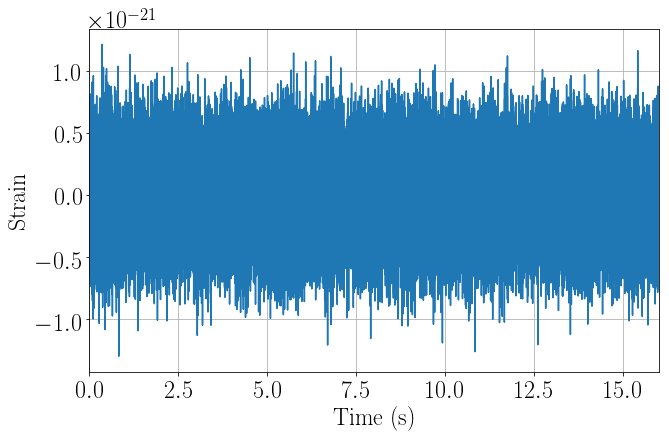

In [3]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab

# Generate some noise with an advanced ligo psd
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.AdVDesignSensitivityP1200087(flen, delta_f, flow)

# Generate 16 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(16 / delta_t)
strain = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

plt.plot(strain.sample_times, strain)
plt.xlim(0,16)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

# Generating Waveform

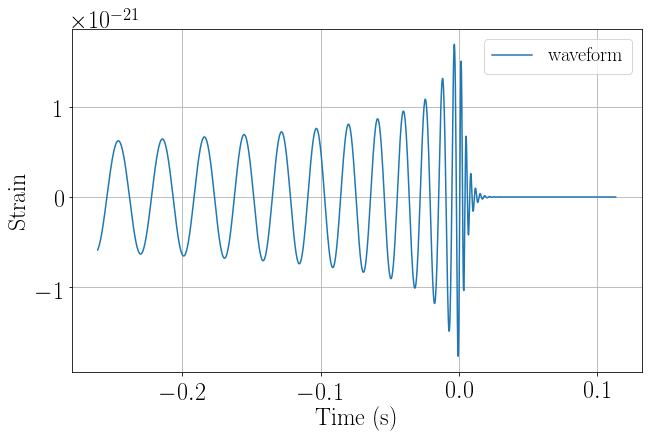

In [4]:
# Use a waveform as a matched filter
hp, hc = pycbc.waveform.get_td_waveform(approximant="SEOBNRv4",
                             mass1=30, mass2=30,distance=400,
                             f_lower=flow, delta_t=delta_t)

plt.plot(hp.sample_times,hp,label='waveform')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [5]:
hp_taper = pycbc.waveform.utils.taper_timeseries(hp,tapermethod='startend')

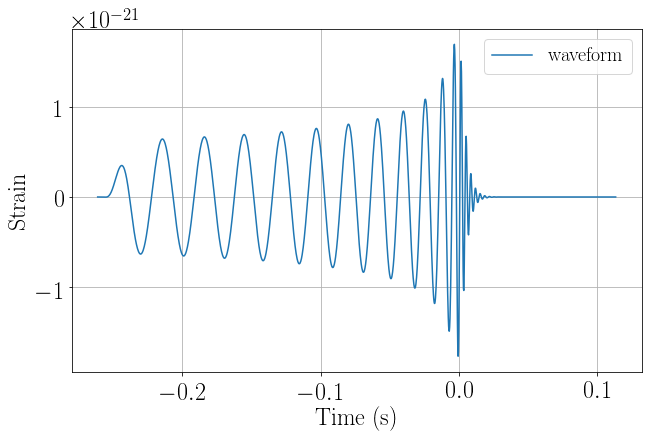

In [6]:
plt.plot(hp_taper.sample_times,hp_taper,label='waveform')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# Injecting the waveform into the noise

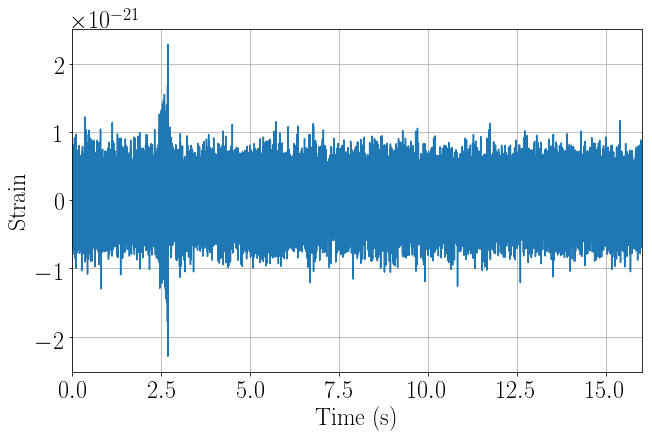

In [7]:
noise_len = np.size(strain.sample_times)
waveform_len = np.size(hp.sample_times)
for i in range(waveform_len):
    strain[i+10000] += hp[i] 
    
plt.plot(strain.sample_times, strain)
plt.xlim(0,16)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

# Match filtering SNR

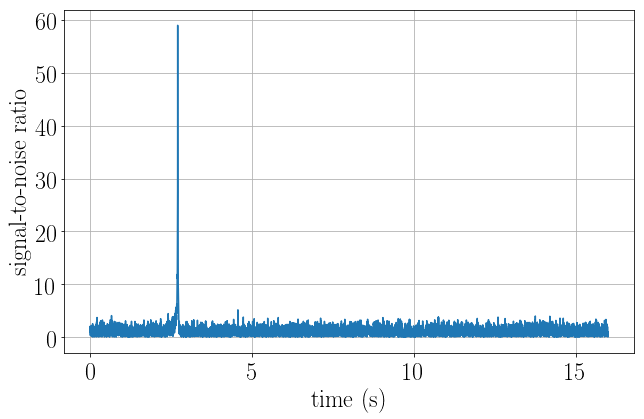

In [9]:
stilde = strain.to_frequencyseries()

# Use a waveform as a matched filter
hp_filter, _ = pycbc.waveform.get_fd_waveform(approximant="IMRPhenomPv2",
                             mass1=30, mass2=30,distance=400,
                             f_lower=flow, delta_f=stilde.delta_f)

hp_filter.resize(len(stilde))

snr = pycbc.filter.matched_filter(hp_filter, stilde, psd=psd,
                                      low_frequency_cutoff=flow)

plt.plot(snr.sample_times, abs(snr))
plt.ylabel('signal-to-noise ratio')
plt.xlabel('time (s)')
plt.show()